In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
# from torchvision.transforms import ToTensor
from tqdm import trange, tqdm
from matplotlib import pyplot as plt
from model import LSTM

In [4]:
# Locate the data
mp_data_path = '/home/prashtata/gradschool/asl/dataset/MP_data'
label_list = os.listdir(mp_data_path) #Since the labels are the directory names, we shall use them

# print(len(label_list))

data = []
labels = []
num_labels = len(label_list)
# num_labels = 10
for i in range(num_labels):

    # List the samples under the label
    label_dir = os.path.join(mp_data_path, label_list[i])
    sample_list = os.listdir(label_dir)

    # Access the samples
    for sample in sample_list:
        kp_file = os.path.join(label_dir, sample, sample+'_keypoints.npy')
        if not os.path.exists(kp_file):
            continue

        keypoints = np.load(kp_file)
        # print(keypoints.shape)

        # Append the keypoints to the data list and the corresponding label to the labels list
        data.append(keypoints)
        labels.append(i) # Labels will be denoted their index number

In [35]:
print(np.max(data[1200]))

2.338365316390991


In [6]:
print("Unique labels in dataset:", len(np.unique(labels)))

Unique labels in dataset: 1473


In [17]:
print("Sample Keypoint Shape:", data[12000].shape)  # Should be (seq_len, feature_dim)
print("Sample Label:", labels[0])

Sample Keypoint Shape: (35, 258)
Sample Label: 0


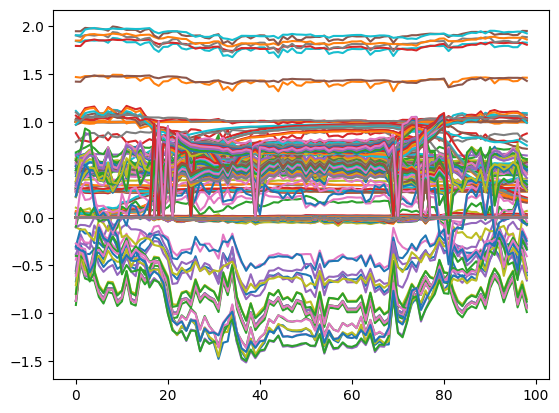

In [29]:
plt.plot(data[12])  # Check for anomalies in keypoints

In [18]:

# Create a dataset class for the above data
class MP_KeypointDataset(Dataset):
    def __init__(self, data, labels, max_seq_len=40):  # Choose a suitable max_seq_len
        self.max_seq_len = max_seq_len
        self.data = [self.pad_or_truncate(torch.tensor(d, dtype=torch.float32)) for d in data]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def pad_or_truncate(self, tensor):
        """Pads or truncates the input tensor to max_seq_len."""
        seq_len, feature_dim = tensor.shape
        if seq_len > self.max_seq_len:
            return tensor[int((seq_len-self.max_seq_len)/2):int((seq_len+self.max_seq_len)/2)]  # Truncate
        else:
            padding = torch.zeros(self.max_seq_len - seq_len, feature_dim)  # Pad
            return torch.cat((tensor, padding), dim=0)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [ ]:
# Initialize the dataset
keypoint_dataset = MP_KeypointDataset(data, labels)

# Split the dataset into train, val and test sets
split_ratio = np.array([0.8, 0.2, 0])
train_dataset, val_dataset, test_dataset = random_split(keypoint_dataset, split_ratio)

train_dataloader = DataLoader(train_dataset, batch_size=4, num_workers=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, num_workers=2, shuffle=False)